# <center> Image classification: person faces

**Case Description**

Facial Recognition is the task of making a positive identification of a face in a photo or video image against a pre-existing database of faces.

**Task**
* Using the data to build Image classification (faces) model (CV task)

**Data**: Images are separated into train and valid subfolders by classes.

**Metrics**: Accuracy

**Computer Vision algorithms**: Using pretrained ResNet model.

*Training on GPU (Kaggle resources)*

*Note: Images classification is an example of supervised machine learning since we train the model with labelled data.*

# 0. Install and Import

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd
import random
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

# Libs for Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
        
import cv2
from PIL import Image

# PyTorch libs
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision import transforms

## Data augmentation libs
# import albumentations as albu
# from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
"""
Set random seeds

Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if installed).
Args:
    seed (:obj:`int`): The seed to set
"""
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed()

In [3]:
# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

# 1. Data Loading: dataset exploration

In [4]:
"""
The first step in any ML tasks is create dataset for further work.
Images are the key element for Computer Vision projects.

There is a usual way to get images by classes as below.
"""
root_directory = "/kaggle/input/faces-dataset-for-cv-project-1/data_faces/"

train_directory = os.path.join(root_directory, "train")
val_directory = os.path.join(root_directory, "valid")

train_filepaths = sorted([os.path.join(train_directory, f) for f in os.listdir(train_directory)])
val_filepaths = sorted([os.path.join(val_directory, f) for f in os.listdir(val_directory)])

train_images_filepaths = sorted([os.path.join(i, f) for i in train_filepaths for f in os.listdir(i)])
val_images_filepaths = sorted([os.path.join(i, f) for i in val_filepaths for f in os.listdir(i)])


print(len(train_images_filepaths), len(val_images_filepaths))

3000 914


But good rule is to create ``class CustomDataset(torch.utils.data.Dataset):`` is an abstract class representing a dataset. Our custom dataset should inherit Dataset.

As an example:
```
class FacesDataset(Dataset):
    """Faces Dataset"""
    def __init__(self, path_data, transforms):
        """
        Arguments:
            path_data (string): Directory with all the images.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        self.path_data = path_data
        self.image_paths = os.listdir(self.path_data)
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Reading of images. This is memory efficient.
        Because all the images are not stored in the memory at once but read as required.
        """
        img_loc = os.path.join(self.path_data, self.image_paths[idx])
        image = Image.open(img_loc).convert("RGB") # or pass .convert("RGB")
        image = self.transforms(image)
        
    return torch.FloatTensor(image)
```


`But in this case our dataset are already separated by train and validation sets. Moreover there are subfolders for each targeted classes. It means that I'm not needed to write custom classes. I can use ImageFolder() from torchvision. It assumes that images are organized in the following way (our folders have the same structure):`

```
data/
|---train/
|   |----class_0/
|   |    |------001.jpg
|   |    |------002.jpg
|   |    |------003.jpg
|   |----class_1/
|        |------004.jpg
|---valid/
    |----class_0/
    |    |------005.jpg
    |    |------006.jpg
    |----class_1/
         |------007.jpg
         |------008.jpg
```

In [5]:
"""
Use ImageFolder()
This class helps us to easily create PyTorch training and validation datasets without writing custom classes
Then we can use these datasets to create our iterable data loaders
"""
df_train = ImageFolder("/kaggle/input/faces-dataset-for-cv-project-1/data_faces/train/")
df_val = ImageFolder("/kaggle/input/faces-dataset-for-cv-project-1/data_faces/valid/")

In [6]:
# Let's look at the total information about our train and validation datasets
img = cv2.imread("/kaggle/input/faces-dataset-for-cv-project-1/data_faces/train/mark_zuckerberg/00f9dd1e-cca0-44f0-bee0-b1ae9d683386.jpg")

print(f"There are {len(df_train)} images in the train dataset")
print(f"There are {len(df_train.classes)} unique targets in the dataset:\n{df_train.classes}")
print(f"Size of each image is {img.shape[0]}x{img.shape[1]}")

print(f"\nThere are {len(df_val)} images in the valid dataset")
print(f"There are {len(df_val.classes)} unique targets in the dataset:\n{df_val.classes}")

There are 3000 images in the train dataset
There are 5 unique targets in the dataset:
['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']
Size of each image is 70x70

There are 914 images in the valid dataset
There are 5 unique targets in the dataset:
['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']


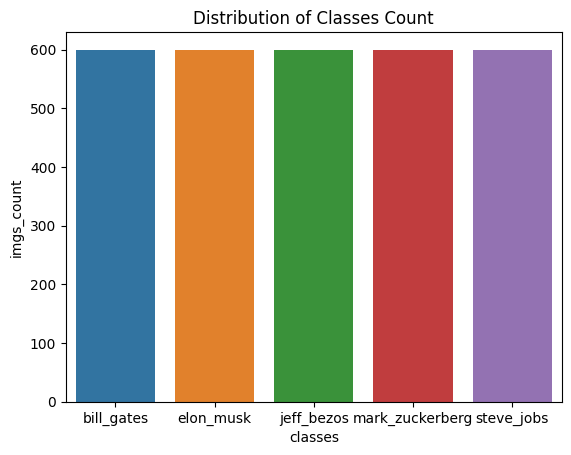

In [7]:
"""
Let's check data representations: images distribution by classes (check Imbalanced data problem)
"""
bill_gates_list = [i for i in range(len(df_train)) if df_train.imgs[i][1] == df_train.class_to_idx["bill_gates"]]
elon_musk_list = [i for i in range(len(df_train)) if df_train.imgs[i][1] == df_train.class_to_idx["elon_musk"]]
jeff_bezos_list = [i for i in range(len(df_train)) if df_train.imgs[i][1] == df_train.class_to_idx["jeff_bezos"]]
mark_zuckerberg_list = [i for i in range(len(df_train)) if df_train.imgs[i][1] == df_train.class_to_idx["mark_zuckerberg"]]
steve_jobs_list = [i for i in range(len(df_train)) if df_train.imgs[i][1] == df_train.class_to_idx["steve_jobs"]]

classes_cnt = pd.DataFrame({
    "classes": ["bill_gates", "elon_musk", "jeff_bezos", "mark_zuckerberg", "steve_jobs"],
    "imgs_count": [len(bill_gates_list), len(elon_musk_list), len(jeff_bezos_list), len(mark_zuckerberg_list), len(steve_jobs_list)]
})

# Distribution of classes_count
sns.barplot(x="classes", y="imgs_count", data=classes_cnt)
plt.title("Distribution of Classes Count")
plt.show()

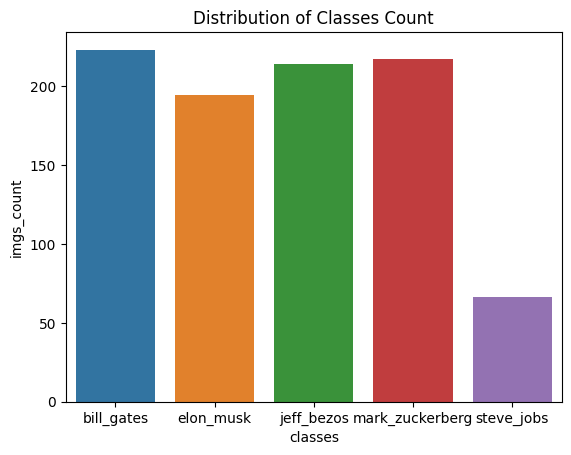

In [8]:
"""
Let's check data representations: images distribution by classes (check Imbalanced data problem) in Validation set
"""
bill_gates_list = [i for i in range(len(df_val)) if df_val.imgs[i][1] == df_val.class_to_idx["bill_gates"]]
elon_musk_list = [i for i in range(len(df_val)) if df_val.imgs[i][1] == df_val.class_to_idx["elon_musk"]]
jeff_bezos_list = [i for i in range(len(df_val)) if df_val.imgs[i][1] == df_val.class_to_idx["jeff_bezos"]]
mark_zuckerberg_list = [i for i in range(len(df_val)) if df_val.imgs[i][1] == df_val.class_to_idx["mark_zuckerberg"]]
steve_jobs_list = [i for i in range(len(df_val)) if df_val.imgs[i][1] == df_val.class_to_idx["steve_jobs"]]

classes_cnt_val = pd.DataFrame({
    "classes": ["bill_gates", "elon_musk", "jeff_bezos", "mark_zuckerberg", "steve_jobs"],
    "imgs_count": [len(bill_gates_list), len(elon_musk_list), len(jeff_bezos_list), len(mark_zuckerberg_list), len(steve_jobs_list)]
})

# Distribution of classes_count
sns.barplot(x="classes", y="imgs_count", data=classes_cnt_val)
plt.title("Distribution of Classes Count")
plt.show()

Some observations:
* Training set: images distribution by classes is equal
* Validation set: there is less variance for some classes (especially "steve_jobs"). It could be a reason of higher accuracy on the validation set than on training as you can see later. Moreover, if the validation set is very small compared to the training then by random the model fits better the validation set than the training

In [9]:
# Checking whether categorical values correspond to each class
df_train.class_to_idx

{'bill_gates': 0,
 'elon_musk': 1,
 'jeff_bezos': 2,
 'mark_zuckerberg': 3,
 'steve_jobs': 4}

In [10]:
# print("Pixel values were scaled to [0,1] interval. e.g:{}".format(img[0][0,:5]))

In [11]:
"""
Show 5*2 Random Face Images from dataset
"""
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    #iterating over samples number
    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title("Face label: {}".format(random_label.replace("_", " ")))
        axes[i].axis("off")
    plt.show()

There are 5 random distinct people from TRAIN dataset


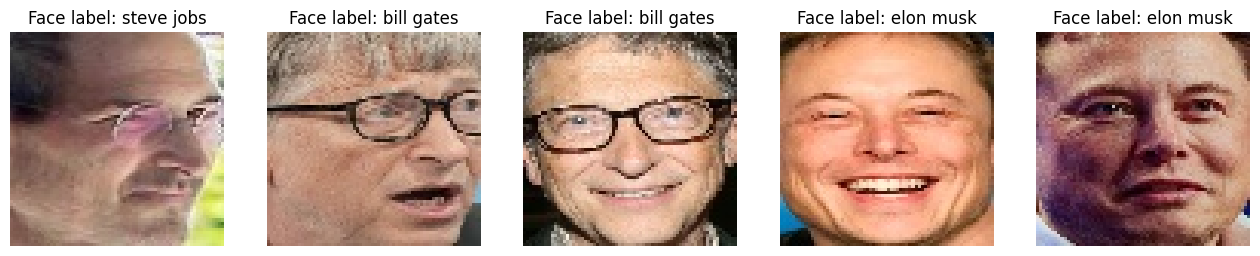

There are 5 random distinct people from VALID dataset


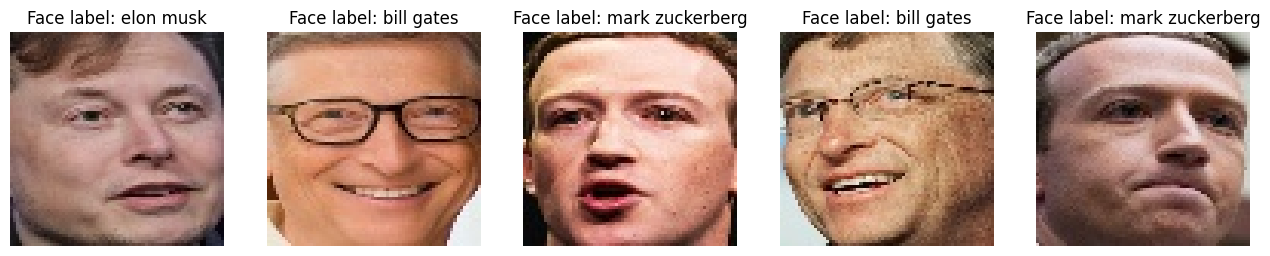

In [12]:
print("There are 5 random distinct people from TRAIN dataset")
plot_samples(df_train)
print("There are 5 random distinct people from VALID dataset")
plot_samples(df_val)

In [13]:
"""
Show 5 Face Images of Selected Target
"""
def show_5_faces_of_n_subject(images, subject_labels):
    cols=5# each subject has 5 distinct face images
    rows=(len(subject_labels)*5)/cols
    rows=int(rows)
    
    fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(18,9))
    #axarr=axarr.flatten()
    
    for i, label in enumerate(subject_labels):
        for j in range(cols):
            idx_list = [i for i in range(len(df_train)) if df_train.imgs[i][1] == df_train.class_to_idx[label]]
            image_index = idx_list[i] + j
            axarr[i,j].imshow(images[image_index][0], cmap="gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title(f"Face label:{label}")

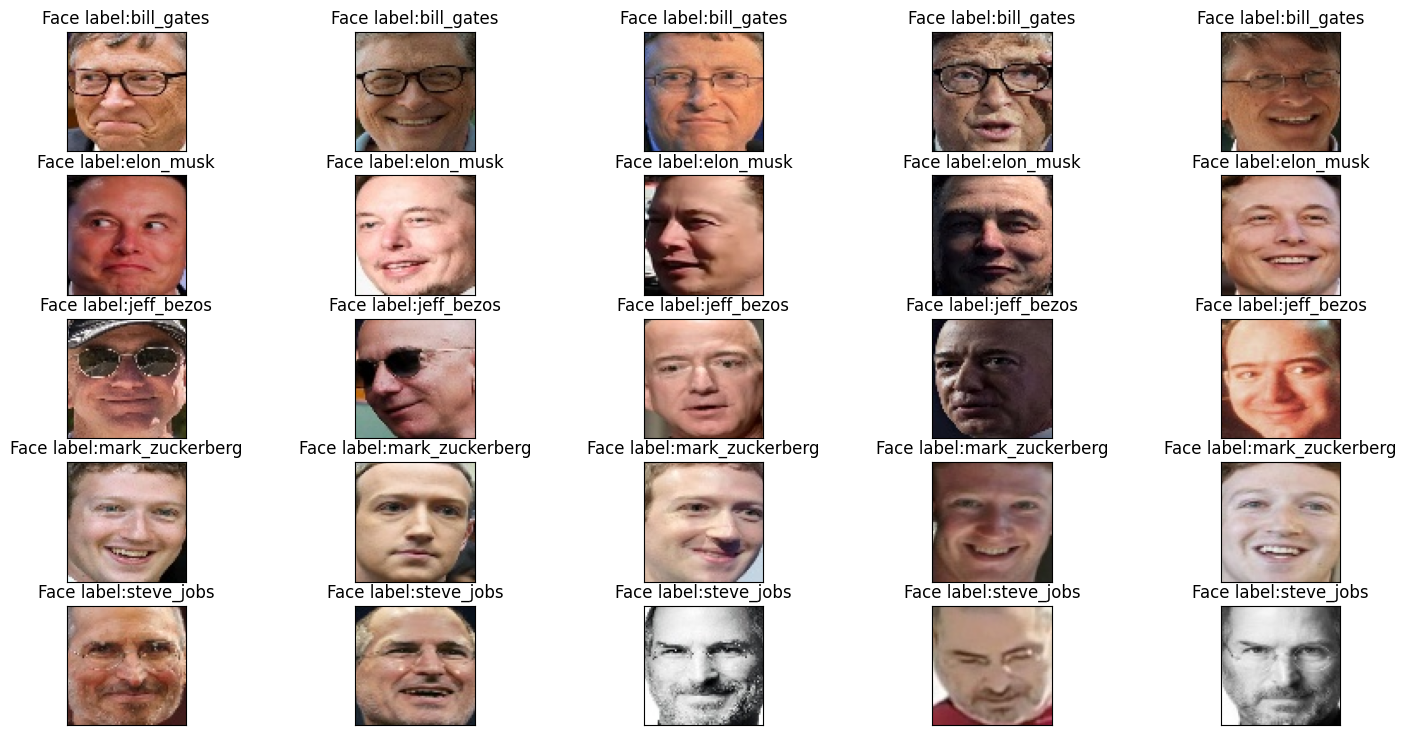

In [14]:
show_5_faces_of_n_subject(images=df_train, subject_labels=["bill_gates", "elon_musk", "jeff_bezos", "mark_zuckerberg", "steve_jobs"])

***

Some observations about Train dataset:
* There are 3000 images
* Total number of classes: 5
* Images Distribution by classes is balanced

I guess that 3k images could be not enough for model training (especial NN models). There is a good practice to increase the size and diversity of dataset - `Data augmentation`. It is the process of applying transformations or modifications to data, such as cropping, flipping, rotating, scaling, or adding noise. It also helps to improve the generalization and robustness of model.

Methods:
* torchvision.transforms (module officially provided by PyTorch)
* albumentations.pytorch.transforms (optimized open source computer vision library)

```
# Imports
from torchvision import transforms as transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Torchvision
transforms_ = transforms.Compose([
                transforms.Resize(224,224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
            ])

# Albumentations:
transforms_ = A.Compose([
                A.augmentations.geometric.resize.SmallestMaxSize(256),
                A.CenterCrop(224),
                A.Resize(224,224),
                A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2()
            ])
```

In [15]:
"""
Preprocess image for ResNet model
"""
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# the training transforms
df_train.transform = transforms.Compose([
    transforms.Resize((64,64)), # 224, 224
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    normalize
])

#the validation transforms
df_val.transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    normalize
])

For the train_transform we are:
* Resizing the images to 64×64 dimensions. This resizing is just to ensure that we do not face any unseen errors during training. `ResNet requires input images to be size 224x224. The last convolutional block feeds into an AdaptiveAvgPool2d(...) layer which feeds into a fully-connected layer with 1000 outputs. These 1000 outputs are the ImageNet classes. Without going into details, the key idea of the AdaptiveAvgPool2d layer is that it takes any input size and always outputs the same size. That's why we can use our images with 64*64 size`
* For the augmentations we are applying RandomHorizontalFlip, RandomVerticalFlip, and RandomResizedCrop. (From experiments: without augmentations, the model was overfitting very soon)
* Finally, we are converting the images to tensors and normalizing them.

For the valid sets transformation, we are just resizing, converting to tensors, and normalizing the images.

In [16]:
"""
Create Dataloader:
Load data from a dataset and create mini-batches for training deep learning models

- shuffle=True - the data is randomly shuffled before each epoch
"""

BATCH_SIZE = 8

train_loader = DataLoader(df_train,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(df_val,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [17]:
X_train, y_train = next(iter(train_loader))

img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))

In [18]:
classes = df_train.classes
classes

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

['bill_gates', 'jeff_bezos', 'steve_jobs', 'bill_gates', 'mark_zuckerberg', 'mark_zuckerberg', 'mark_zuckerberg', 'steve_jobs']


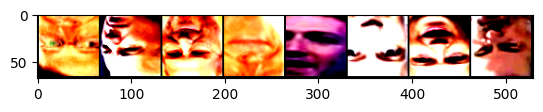

In [19]:
print([classes[i] for i in y_train])
plt.imshow(img)

In [20]:
for images, targets in tqdm(train_loader):
    # Model training step
    ...

  0%|          | 0/375 [00:00<?, ?it/s]

Now I'm ready to move the Modeling stage of this project.

# 3. Model parameters: own CNN model and pretrained ResNet model

In [21]:
"""
Let see if CUDA is available and set the appropriate device for PyTorch so our network can use it
"""
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used: {device}")

Device used: cuda


In [22]:
"""
Loss function for classification task: Cross Entropy
Optimizer: SGD optimizer
"""
criterion = nn.CrossEntropyLoss()
# move criterion to cuda
criterion = criterion.to(device)
#optimizer = torch.optim.SGD([model].parameters(), lr=..., weight_decay =..., et.c)

***

In [23]:
"""
#1 Create own CNN model
"""
class own_CNN_model(nn.Module):
    def __init__(self, num_classes=5):
        """
        In the init function, we define each layer we will use in our model
        - Conv2d:
        Our images are RGB, so we have input channels = 3. 
        We will apply 12 filters in the first convolutional layer
        Second convolutional layer takes 12 input channels, and generates 24 outputs
        - Pooling:
        Apply max pooling with a kernel size of 2
        - Dropout:
        This regularization technique helps prevent overfitting by reducing the reliance on specific neurons
        Drop layer deletes 10% of the features
        - FC layer:
        Our 64x64 image tensors will be pooled twice with a kernel size of 2. 64/2/2 is 16.
        This means that our feature tensors are now 16 x 16, and we've generated 24 of them
        
        We need to flatten these in order to feed them to a fully-connected layer
        """
        
        super(own_CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding="same")
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding="same")
        
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(p=0.1)
        
        self.fc1 = nn.Linear(in_features=24 * 16 * 16, out_features=128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, out_features=64)
        self.fc3 = nn.Linear(64, out_features=num_classes)
        
        
    def forward(self, x):
        """
        In the forward function, pass the data through the layers we defined in the init function
        Use a ReLU activation function after layer 1, 2 (convolution + pool)
        """
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
#         x = self.drop(x)
    
        # Flatten
        x = x.view(-1, 16 * 16 * 24)
        # Feed to fully-connected layer to predict class
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return torch.log_softmax(x, dim=1) # x
    
    
own_cnn = own_CNN_model(num_classes=len(df_train.classes))
print(own_cnn)

own_CNN_model(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=6144, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)


***

In [24]:
"""
#2 ResNet model: replace output classes number (1000 -> 5)

We have only 600*5 examples in training sets. And it is not enough if we want to train a Convolutional Neural Network from scratch
That's why it has a sense to use pre-trained ImageNet models.

I choose ResNet

Unlike traditional sequential network architectures such as AlexNet, OverFeat, and VGG,
ResNet is instead a form of “exotic architecture” that relies on micro-architecture modules
(also called “network-in-network architectures”).
"""
model_resnet = models.resnet34()

In [25]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
"""
Fully-connected layer of this model creates predictions for 1000 classes
"""
model_resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [27]:
# Let's replace out_features=5 instead of 1000
model_resnet.fc = nn.Linear(512, len(df_train.classes))
model_resnet.fc

Linear(in_features=512, out_features=5, bias=True)

***

In [28]:
"""
#3 ResNet model: using pretrained weights
"""
model_net_pretrained = models.resnet34(pretrained=True) #pretrained=True - using pre-trained weights based on ImageNet
model_net_pretrained.fc = nn.Linear(512, len(df_train.classes)) # replace fully-connected layer output value

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s] 


***

In [29]:
"""
#4 ResNet model:
Freezing layers and Fine-tuning

Let's freeze all layers by setting the requires_grad attribute to False
After that we create FC-layer with our classes number as output
"""
# model_fine_tuned = models.resnet34(pretrained=True)

# for parameter in model_fine_tuned.parameters():
#     parameter.requres_grad = False
    
# model_fine_tuned.fc = nn.Linear(512, len(df_train.classes))

"""
Let's create class with our fine-tuned model
"""

class FacesRecognitionModel(nn.Module):
    def __init__(self, net_name = "resnet34", pretrain=True, input_=512, output=len(df_train.classes)):
        """
        Architecture:
        - Pretrained model
        - Final FC linear layer to get output for multiclass classification
        """
        super(FacesRecognitionModel, self).__init__()
        
        # Load pretrained ResNet
        MODEL = getattr(models, net_name)
        self.net = MODEL(pretrained=pretrain)
        
#         self.net.fc = nn.Linear(in_features=input_, out_features=output)
        # Let's add more Linear layers to 
        self.net.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(256, out_features=128),
            nn.Linear(128, out_features=len(df_train.classes))
        )
        
        for index, param in enumerate(self.net.parameters()):
             if index >= 88: # output = 512
                    param.requres_grad = True
    
    
    def forward(self, x: torch.Tensor):
        x = self.net(x)

        return torch.log_softmax(x, dim=1)
    

model_fine_tuned = FacesRecognitionModel()
model_fine_tuned

FacesRecognitionModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

# 4. Model training

In [30]:
"""
Function to train models
"""
def train_model(model, optimizer, train_dataset, valid_dataset, num_epochs=10):
    loss_train = []
    acc_train = []
    loss_valid = []
    acc_valid = []
    
    for epoch in range(num_epochs):
        # sets gradient calculation for train data
        torch.set_grad_enabled(True)
        model.train()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(train_loader)):
            # move images and target to CUDA (GPU)
            images = images.to(device)
            target = target.to(device)

            # Get model prediciton and Loss
            output = model(images)
            loss = criterion(output, target)

            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])
            
            """
            * zero_grad clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
            * loss.backward() computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation.
            * optimizer.step() causes the optimizer to take a step based on the gradients of the parameters.
            """
            
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward() # calculate the gradients
            optimizer.step()
            
        # Compute metrics    
        loss_train.append(np.mean(losses))
        acc_train.append(np.mean(equals))
        print(f'Epoch: {epoch+1}. Loss (train): {loss_train[epoch]:.3f}. Accuracy: (train): {acc_train[epoch]:.3f}')
        
        # Clean garbage data
        torch.cuda.empty_cache()
        
        
        # Validation step
        
        # Eval model turns off some features like dropout and batch normalization.
        # Does not automatically disable gradient computation for all operations.
        
        torch.set_grad_enabled(False)
        model.eval()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(valid_loader)):
            images = images.to(device)
            target = target.to(device)
            
            # Get model prediciton and Loss
            output = model(images)
            loss = criterion(output, target)

            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # don't need the step of zero the parameter gradients
            ...

        loss_valid.append(np.mean(losses))
        acc_valid.append(np.mean(equals))
        print(f'Epoch: {epoch+1}. Loss (valid): {loss_valid[epoch]:.3f}. Accuracy: (valid): {acc_valid[epoch]:.3f}')
        
        # Clean garbage data
        torch.cuda.empty_cache()

    return loss_train, acc_train, loss_valid, acc_valid

***

In [31]:
"""
# 1: Own CNN model training
Epoch number = 10
"""
own_cnn = own_cnn.to(device)
optimizer = torch.optim.SGD(own_cnn.parameters(), lr=1e-2, weight_decay=1e-4)

In [32]:
loss_train, acc_train, loss_valid, acc_valid = train_model(own_cnn, optimizer, df_train, df_val, 10)

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 1. Loss (train): 1.589. Accuracy: (train): 0.253


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 1. Loss (valid): 1.546. Accuracy: (valid): 0.299


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 2. Loss (train): 1.536. Accuracy: (train): 0.321


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 2. Loss (valid): 1.462. Accuracy: (valid): 0.386


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 3. Loss (train): 1.464. Accuracy: (train): 0.381


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 3. Loss (valid): 1.349. Accuracy: (valid): 0.434


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 4. Loss (train): 1.426. Accuracy: (train): 0.406


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 4. Loss (valid): 1.365. Accuracy: (valid): 0.423


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 5. Loss (train): 1.376. Accuracy: (train): 0.416


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 5. Loss (valid): 1.123. Accuracy: (valid): 0.547


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 6. Loss (train): 1.339. Accuracy: (train): 0.434


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 6. Loss (valid): 1.031. Accuracy: (valid): 0.582


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 7. Loss (train): 1.322. Accuracy: (train): 0.453


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 7. Loss (valid): 1.043. Accuracy: (valid): 0.579


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 8. Loss (train): 1.286. Accuracy: (train): 0.476


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 8. Loss (valid): 1.076. Accuracy: (valid): 0.585


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 9. Loss (train): 1.253. Accuracy: (train): 0.490


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 9. Loss (valid): 1.050. Accuracy: (valid): 0.574


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 10. Loss (train): 1.238. Accuracy: (train): 0.496


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 10. Loss (valid): 0.848. Accuracy: (valid): 0.678


`Useful Tip: in case of a n-class classification with categorical cross entropy the loss on the first epoch should be -ln(1/n)`
* -ln(1/5) ~ 1,609
* Our model result = 1.589. Results make sense!

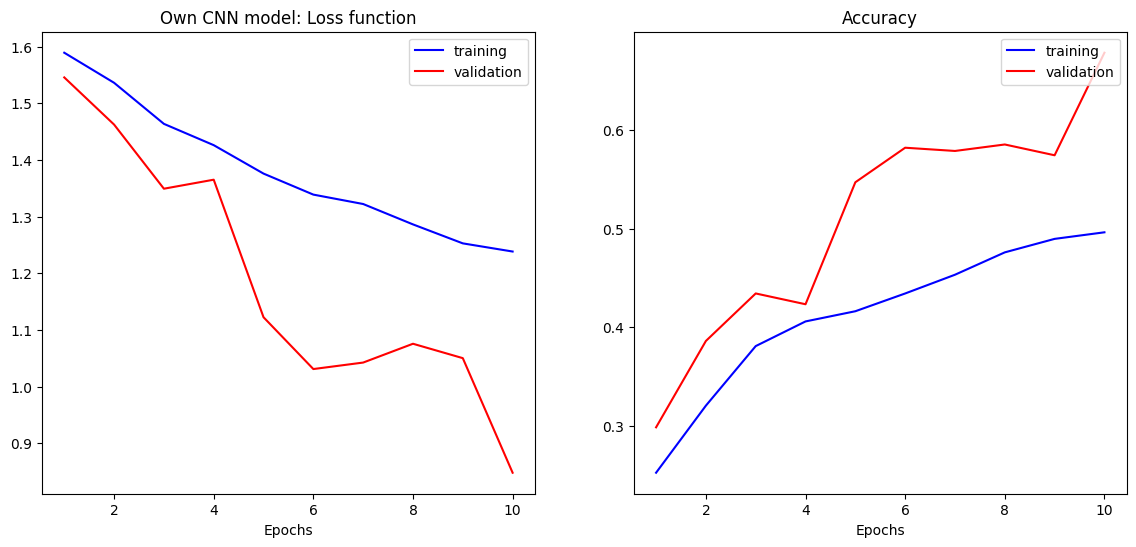

In [33]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Epochs")
plt.legend(["training", "validation"], loc="upper right")
plt.title("Own CNN model: Loss function")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), acc_train, color="b")
plt.plot(range(1, len(loss_train) + 1), acc_valid, color="r")
plt.xlabel("Epochs")
plt.legend(["training", "validation"], loc="upper right")
plt.title("Accuracy")

plt.show()

Some observations:
* Epochs number = 10
* Accuracy score on validation set = 0.678
* The accuracy values haven’t even begun to reach a plateau (is has a sense to decrease lr and epoch number)

***

In [34]:
"""
# 2: Training based on the ResNet model
Epoch number = 10

Using all the default options for SGD optimizer (as for ResNet)
- learning rate is less than in default options because of dataset's size
"""
# move model to cuda
model_resnet = model_resnet.to(device)

optimizer = torch.optim.SGD(model_resnet.parameters(), lr=1e-2, weight_decay=1e-4)

In [35]:
loss_train, acc_train, loss_valid, acc_valid = train_model(model_resnet, optimizer, df_train, df_val, 10)

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 1. Loss (train): 1.870. Accuracy: (train): 0.260


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 1. Loss (valid): 1.858. Accuracy: (valid): 0.293


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 2. Loss (train): 1.692. Accuracy: (train): 0.293


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 2. Loss (valid): 1.865. Accuracy: (valid): 0.278


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 3. Loss (train): 1.538. Accuracy: (train): 0.346


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 3. Loss (valid): 1.512. Accuracy: (valid): 0.394


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 4. Loss (train): 1.405. Accuracy: (train): 0.421


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 4. Loss (valid): 1.278. Accuracy: (valid): 0.487


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 5. Loss (train): 1.304. Accuracy: (train): 0.466


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 5. Loss (valid): 1.066. Accuracy: (valid): 0.528


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 6. Loss (train): 1.246. Accuracy: (train): 0.490


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 6. Loss (valid): 1.210. Accuracy: (valid): 0.600


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 7. Loss (train): 1.219. Accuracy: (train): 0.504


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 7. Loss (valid): 0.678. Accuracy: (valid): 0.751


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 8. Loss (train): 1.142. Accuracy: (train): 0.544


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 8. Loss (valid): 0.715. Accuracy: (valid): 0.742


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 9. Loss (train): 1.101. Accuracy: (train): 0.556


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 9. Loss (valid): 1.163. Accuracy: (valid): 0.619


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 10. Loss (train): 1.067. Accuracy: (train): 0.580


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 10. Loss (valid): 0.649. Accuracy: (valid): 0.763


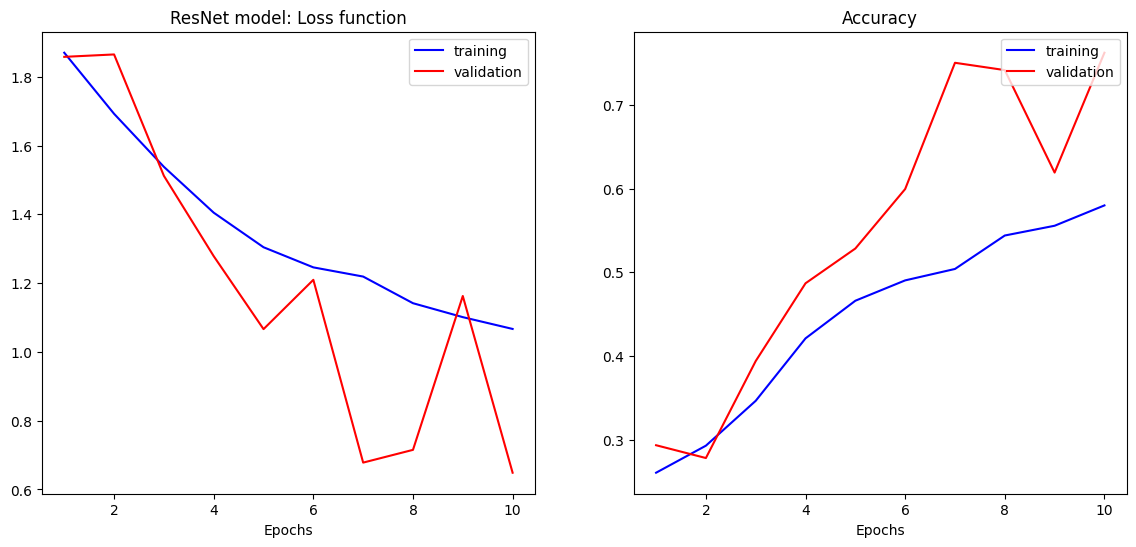

In [36]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Epochs")
plt.legend(["training", "validation"], loc="upper right")
plt.title("ResNet model: Loss function")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), acc_train, color="b")
plt.plot(range(1, len(loss_train) + 1), acc_valid, color="r")
plt.xlabel("Epochs")
plt.legend(["training", "validation"], loc="upper right")
plt.title("Accuracy")

plt.show()

Some observations:
* Epochs number = 10
* Accuracy score on validation set = 0.763
* The accuracy values haven’t even begun to reach a plateau (is has a sense to decrease lr)

But anyway the result doesn't look as stable.

***

In [37]:
"""
#3 ResNet model: using pretrained weights
Epoch number = 10

Learning rate is less because of using pretrained weights
"""
# move model to cuda
model_net_pretrained = model_net_pretrained.to(device)

optimizer = torch.optim.SGD(model_net_pretrained.parameters(), lr=1e-3, weight_decay=1e-4)

In [38]:
loss_train, acc_train, loss_valid, acc_valid = train_model(model_net_pretrained, optimizer, df_train, df_val, 10)

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 1. Loss (train): 1.394. Accuracy: (train): 0.422


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 1. Loss (valid): 1.061. Accuracy: (valid): 0.563


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 2. Loss (train): 1.058. Accuracy: (train): 0.571


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 2. Loss (valid): 0.857. Accuracy: (valid): 0.660


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 3. Loss (train): 0.966. Accuracy: (train): 0.623


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 3. Loss (valid): 0.648. Accuracy: (valid): 0.771


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 4. Loss (train): 0.859. Accuracy: (train): 0.662


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 4. Loss (valid): 0.553. Accuracy: (valid): 0.813


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 5. Loss (train): 0.781. Accuracy: (train): 0.706


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 5. Loss (valid): 0.499. Accuracy: (valid): 0.824


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 6. Loss (train): 0.727. Accuracy: (train): 0.731


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 6. Loss (valid): 0.450. Accuracy: (valid): 0.836


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 7. Loss (train): 0.682. Accuracy: (train): 0.742


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 7. Loss (valid): 0.362. Accuracy: (valid): 0.882


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 8. Loss (train): 0.645. Accuracy: (train): 0.766


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 8. Loss (valid): 0.298. Accuracy: (valid): 0.902


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 9. Loss (train): 0.632. Accuracy: (train): 0.755


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 9. Loss (valid): 0.298. Accuracy: (valid): 0.898


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 10. Loss (train): 0.599. Accuracy: (train): 0.782


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 10. Loss (valid): 0.244. Accuracy: (valid): 0.922


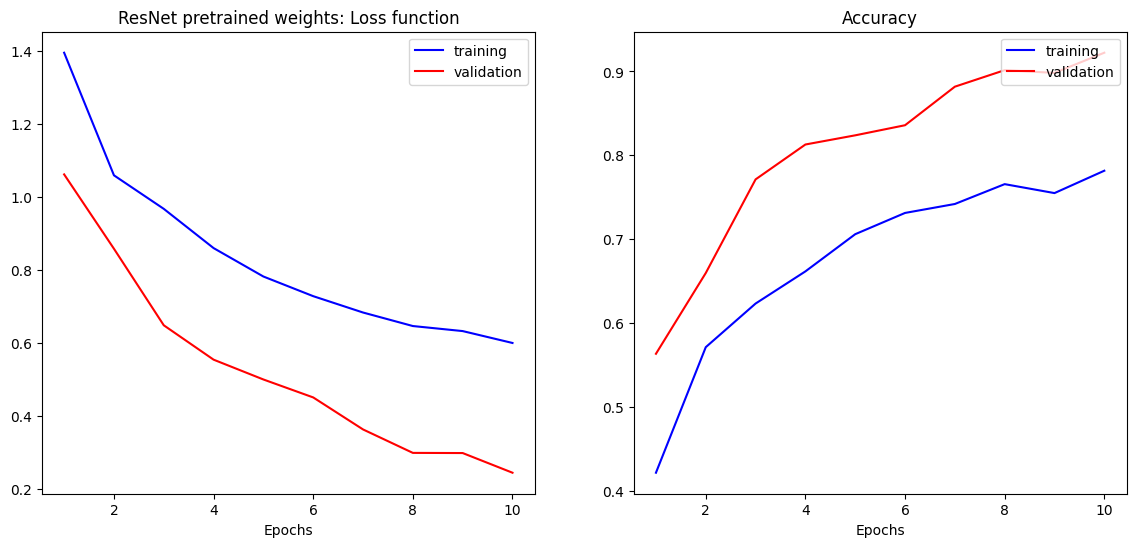

In [39]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Epochs")
plt.legend(["training", "validation"], loc="upper right")
plt.title("ResNet pretrained weights: Loss function")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), acc_train, color="b")
plt.plot(range(1, len(loss_train) + 1), acc_valid, color="r")
plt.xlabel("Epochs")
plt.legend(["training", "validation"], loc="upper right")
plt.title("Accuracy")

plt.show()

Some observations:
* Epochs number = 10 (the same as on previous step).
* Accuracy score on validation set shows better result after training model with pretrained weghts = 0.922

It means that using model with pretrained weghts allows us to achieve better quality.

***

In [40]:
"""
#4 ResNet model:
Freezing layers and Fine-tuning
Epoch number = 10
"""
# move model to cuda
model_fine_tuned = model_fine_tuned.to(device)

optimizer = torch.optim.SGD(model_fine_tuned.parameters(), lr=1e-3, weight_decay=1e-4)

In [41]:
loss_train, acc_train, loss_valid, acc_valid = train_model(model_fine_tuned, optimizer, df_train, df_val, 10)

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 1. Loss (train): 1.581. Accuracy: (train): 0.290


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 1. Loss (valid): 1.471. Accuracy: (valid): 0.429


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 2. Loss (train): 1.469. Accuracy: (train): 0.420


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 2. Loss (valid): 1.242. Accuracy: (valid): 0.526


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 3. Loss (train): 1.281. Accuracy: (train): 0.496


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 3. Loss (valid): 1.030. Accuracy: (valid): 0.611


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 4. Loss (train): 1.149. Accuracy: (train): 0.555


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 4. Loss (valid): 0.925. Accuracy: (valid): 0.629


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 5. Loss (train): 1.029. Accuracy: (train): 0.589


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 5. Loss (valid): 0.861. Accuracy: (valid): 0.688


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 6. Loss (train): 0.943. Accuracy: (train): 0.637


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 6. Loss (valid): 0.744. Accuracy: (valid): 0.726


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 7. Loss (train): 0.915. Accuracy: (train): 0.637


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 7. Loss (valid): 0.607. Accuracy: (valid): 0.814


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 8. Loss (train): 0.819. Accuracy: (train): 0.688


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 8. Loss (valid): 0.556. Accuracy: (valid): 0.833


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 9. Loss (train): 0.763. Accuracy: (train): 0.706


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 9. Loss (valid): 0.448. Accuracy: (valid): 0.856


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 10. Loss (train): 0.724. Accuracy: (train): 0.731


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch: 10. Loss (valid): 0.393. Accuracy: (valid): 0.885


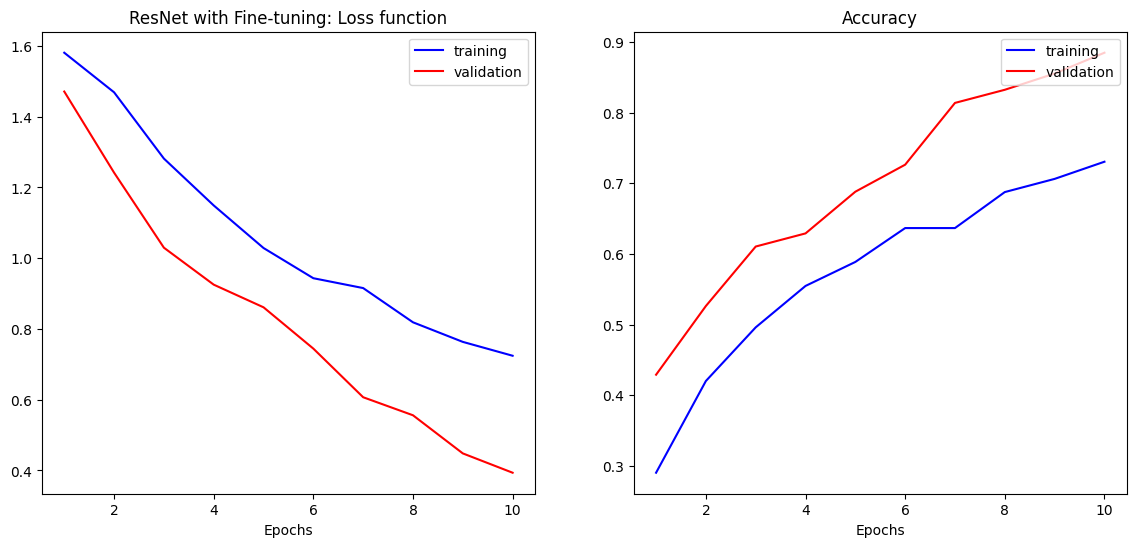

In [42]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Epochs")
plt.legend(["training", "validation"], loc="upper right")
plt.title("ResNet with Fine-tuning: Loss function")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), acc_train, color="b")
plt.plot(range(1, len(loss_train) + 1), acc_valid, color="r")
plt.xlabel("Epochs")
plt.legend(["training", "validation"], loc="upper right")
plt.title("Accuracy")

plt.show()

Some observations:
* Epochs number = 10 (the same as on previous steps).
* Accuracy score on validation set = 0.885

On all the graphs there is the next situation: Accuracy on validation set is higher than on train.

`What is the reason of that and How can we solve it?`
* If the validation set is very small compared to the training then by random the model fits better the validation set than the training
* There is less variance for some classes in validation set.

How to solve:
* Train for longer time: increase the epoch times
* Using another advanced optimization algorithms
* Decrease Learning rate, et.c.
* Solve problem with imbalanced data

***

Getting predictions from test set...


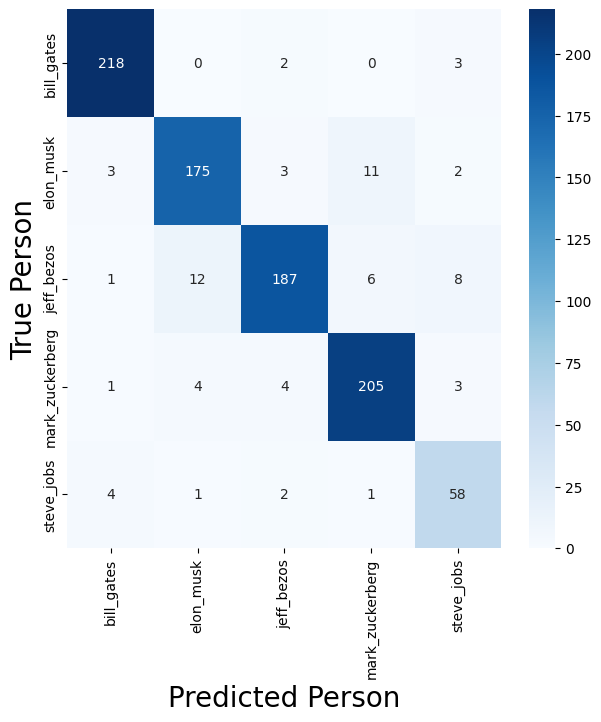

In [43]:
# Defining Labels and Predictions
truelabels = []
predictions = []

model_net_pretrained.eval().to("cpu")
print("Getting predictions from test set...")

for data, target in valid_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model_net_pretrained(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(df_train.classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt="g")
plt.xlabel("Predicted Person", fontsize = 20)
plt.ylabel("True Person", fontsize = 20)
plt.show()

We can see that there is not a lot of mislassification among our classes. Model based on pretrained weights of ResNet shows good result!

# 5. Model prediction

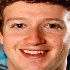

In [44]:
image = Image.open("/kaggle/input/faces-dataset-for-cv-project-1/data_faces/valid/mark_zuckerberg/c0713ac0-ae86-41a3-8f5b-b5b91296e53a.jpg")
image

In [45]:
tensor = df_val.transform(image)
batch = torch.stack([tensor]) # batch size = 1

with torch.no_grad():
    output = model_net_pretrained.to(device)(batch.to(device)).to("cpu")
    
predicted = output.argmax().item()

In [46]:
df_train.classes[predicted]

'mark_zuckerberg'

We get correct class!

***

In [47]:
"""
(Optional)
Save and load model
Export model to onnx format
"""
dir = os.path.abspath(os.curdir)

PATH = os.path.join(dir, "my_resnet.onnx")
#(1, 3, 224, 224) – model's parameters, 3 color channel, 224х224 pixel (ResNet),
dummy_input = Variable(torch.randn(1, 3, 224, 224).to(device))
torch.onnx.export(model_net_pretrained, dummy_input, PATH)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [48]:
path = os.path.join(os.path.abspath(os.curdir), "my_resnet.onnx")

# initialize the list of class labels 
CLASSES = df_train.classes

# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromONNX(path)

[INFO] loading model...
